# ML-7. Домашнее задание (HW-3)

Прогнозирование биологического ответа

In [10]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
#import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import learning_curve
import time

%matplotlib inline
#plt.style.use('seaborn')

In [11]:
import warnings # для игнорирования предупреждений
# Игнорируем предупреждения
warnings.filterwarnings('ignore')



In [12]:
# создадим пустой словарь складывать результаты для финального обзора...
res_dict={}

## Читаем и разделяем данные

In [13]:
# прочитаем данные...
data = pd.read_csv('_train_sem09.csv')

# Предварительная обработка не требуется, данные уже закодированы и нормализованы.
# В качестве метрики будем использовать F1-score.

In [14]:
# Отделим биологический твет (как целевой признак)
y = data['Activity']

# ...и определим массив экспериметальных данных
x = data.drop(['Activity'],axis=1)

Activity
1    0.542255
0    0.457745
Name: proportion, dtype: float64

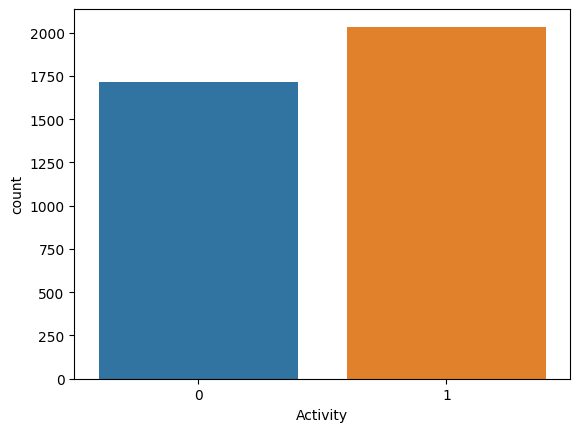

In [15]:
# проверим соотошение классов в целевом признаке
display(data['Activity'].value_counts(True))
sns.countplot(data=data, x='Activity');


In [16]:
# Разделим массив на Тренировочный и Тестовый
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

## Строим базовые 2 модели - Логистическую регрессию и Случайный Лес

In [17]:
# Определим функцию, которя будет измерять сремя исполнения кода...
def dura(start,end):
    return round(end-start,5)

In [26]:
# Обучаем Логистическую регрессию
start = time.time()
lr = linear_model.LogisticRegression(max_iter=50, random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# рассчитаем метрику F1-score
score = metrics.f1_score(y_test, y_pred)

end = time.time()
# запишем результат в словарь:
res_dict['LogRegr_BaseLine'] = [round(score,4), dura(start,end)]

print('Метрика F1 для Логистической регресии = {}'.format(round(score,4)))

Метрика F1 для Логистической регресии = 0.7663
CPU times: total: 516 ms
Wall time: 304 ms


In [24]:
# Обучаем Случайный лес
start = time.time()

rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# рассчитаем метрику F1-score
score = metrics.f1_score(y_test, y_pred)

end = time.time()

# запишем результат в словарь:
res_dict['RandForest_BaseLine'] = [round(score,4),dura(start,end)]

print('Метрика F1 для "Случайного леса" = {}'.format(round(score,4)))

Метрика F1 для "Случайного леса" = 0.8145


Кривая обучения (learning curve) — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели. Будем прибегать к ней ниже в коде...

In [27]:
# Функция из курса, рекомендованная к использованию для визуализации кривых обучения...

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

## Подбираем гиперпараметры для Логистической регрессии: 

### LogRegr + GridSearchCV

In [28]:
# сначала импорт...
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

start = time.time()

# Определяем сетку гиперпараметров:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]} # уровень силы регуляризации
              ]

# создаем объект класса GridSearchCV...
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    verbose=False
)
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = StratifiedKFold(n_splits=5)

# %time - замеряет время выполнения
# %time grid_search.fit(X_train, y_train)
grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

end = time.time()

print('Метрика F1 для Логистической регресии и GridSearch: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

In [30]:
# запишем результат в словарь:
res_dict['LogRegr_GridSearch'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

In [ ]:
# построим Кривую обучения (Learning curve)
# plot_learning_curve(grid_search, X_train, y_train,cv=skf, scoring="f1", ax=None, title="")

### LogRegr + RANDOMIZEDSEARCHCV 

In [33]:
# импортируем библиотеку...
from sklearn.model_selection import RandomizedSearchCV

start = time.time()

param_set = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator = lr,  #inear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_set, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)

random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)

end = time.time()

print('Метрика F1 для Логистической регресии и RANDOMIZEDSEARCHCV: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

Метрика F1 для Логистической регресии и RANDOMIZEDSEARCHCV: 0.7752


In [36]:
# запишем результат в словарь:
res_dict['LogRegr_RandSearch'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

### LogRegr + HYPEROPT

In [39]:
# делаем импорт и выведем версию библиотеки
# from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


In [40]:
# зададим пространство поиска гиперпараметров
start = time.time()

pen = ['l2', 'none']
sol = ['lbfgs', 'sag']

space = {'penalty':hp.choice('penalty', pen),
         'solver':hp.choice('solver',sol),
         'C':hp.uniform('C', 0.01, 1)
         }
# зафксируем random_state
random_state = 42

def hyperopt_lr(params, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_lr, # наша функция 
        space=space, # пространство гиперпараметров
        algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
        max_evals=50, # максимальное количество итераций
        trials=trials, # логирование результатов
        rstate=np.random.default_rng(random_state)
        )

# рассчитаем точность для тестовой выборки по найденный гиперпараметрам - подставим найденные параметры в модель
model = linear_model.LogisticRegression(
    random_state=random_state,
    max_iter=20,                       
    penalty = pen[best['penalty']],     # подставляем найденные параметры в модель
    solver = sol[best['solver']],       # подставляем найденные параметры в модель
    C = float(best['C'])                # подставляем найденные параметры в модель
)
# обучаем модель...
model.fit(X_train, y_train)

# найдем предсказание...
y_test_pred = model.predict(X_test)

end = time.time()

# рассчитаем точность для тестовой выборки
print('Метрика F1 для Логистической регресии и HYPEROPT: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [01:01<00:00,  1.24s/trial, best loss: -0.9063647490820074]
Метрика F1 для Логистической регресии и HYPEROPT: 0.7734


In [44]:
# запишем результат в словарь:
res_dict['LogRegr_HyperOpt'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

### LogRegr + OPTUNA

In [46]:
import optuna

# print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.0


In [55]:
start = time.time()

def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', pen)
  solver = trial.suggest_categorical('solver', sol)
  C = trial.suggest_float('C', 0.1, 1)

  # создаем модель
  model = linear_model.LogisticRegression(
    random_state=random_state,
    penalty=penalty,
    solver=solver,
    C=C
    )
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test))
  return score
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=25)
optuna.logging.set_verbosity(optuna.logging.INFO)

end = time.time()

In [48]:
# выводим результаты на обучающей выборке
# print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Метрика F1 для Логистической регресии и OPTUNA: {:.4f}".format(study.best_value))

Метрика F1 для Логистической регресии и OPTUNA: 0.7796


In [52]:
res_dict['LogRegr_Optuna'] = [round(study.best_value,4), dura(start,end)]

## Подбираем гиперпараметры для "Случайного леса": 

### RandomForestClassifier + GridSearchCV

In [56]:
start = time.time()
# Определяем сетку гиперпараметров:
param_grid = [
{'max_depth': [5, 8, 10],
'min_samples_leaf': [7, 8, 9],  #первый словарь 
'n_estimators': [100, 200, 300]} 
]

# создаем объект класса GridSearchCV...
grid_search = GridSearchCV(
    estimator = rf,
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

end = time.time()

print('Метрика F1 для Случайного леса и GridSearch: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Метрика F1 для Случайного леса и GridSearch: 0.8000


In [58]:
res_dict['RandForest_GridSearch'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

### RandomForestClassifier + RANDOMIZEDSEARCHCV 

In [60]:
start = time.time()

param_set = {'min_samples_leaf': list(np.linspace(100, 300, 1, dtype=int)),
              'max_depth': list(np.linspace(2, 30, 1, dtype=int)),
              'min_samples_leaf':list(np.linspace(2, 10, 1, dtype=int))
              }
            
            
random_search = RandomizedSearchCV(
    estimator = rf, # - наша модель RandomForestClassifier
    param_distributions=param_set, 
    cv=5, 
    n_iter = 20,
    n_jobs = -1
)

random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)

end = time.time()

print('Метрика F1 для Случайного леса и RANDOMIZEDSEARCHCV: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

Метрика F1 для Случайного леса и RANDOMIZEDSEARCHCV: 0.7463


In [61]:
res_dict['RandForest_RandSearch'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

### RandomForestClassifier + HYPEROPT

In [63]:
start = time.time()

space={'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# Рассчитаем точность для тестовой выборки по найденным гиперпараметрам - подставим найденные параметры в модель
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
# обучаем модель...
model.fit(X_train, y_train)

# найдем предсказание...
y_test_pred = model.predict(X_test)

end = time.time()

# рассчитаем точность для тестовой выборки
print('Метрика F1 для Случайного леса и HYPEROPT: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 50/50 [02:20<00:00,  2.82s/trial, best loss: -0.9920731707317074]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 2.0, 'n_estimators': 216.0}
Метрика F1 для Случайного леса и HYPEROPT: 0.8221


In [64]:
res_dict['RandForest_HyperOpt'] = [round(metrics.f1_score(y_test, y_test_pred),4),dura(start,end)]

### RandomForestClassifier + OPTUNA

In [70]:
start = time.time()

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
    max_depth = trial.suggest_int('max_depth', 2, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

# обучаем модель
model.fit(X_train, y_train)

# cоздаем объект исследования
# указываем напрямую, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=25)
optuna.logging.set_verbosity(optuna.logging.INFO)

end = time.time()

# выводим результаты на обучающей выборке
# print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Метрика F1 для Случайного леса и OPTUNA: {:.4f}".format(study.best_value))

[I 2024-03-21 12:22:11,260] A new study created in memory with name: RandomForestClassifier
[I 2024-03-21 12:22:13,739] Trial 0 finished with value: 0.8925219497426582 and parameters: {'n_estimators': 230, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8925219497426582.
[I 2024-03-21 12:22:18,806] Trial 1 finished with value: 0.9920731707317074 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9920731707317074.
[I 2024-03-21 12:22:22,079] Trial 2 finished with value: 0.9392466585662211 and parameters: {'n_estimators': 242, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9920731707317074.
[I 2024-03-21 12:22:22,667] Trial 3 finished with value: 0.7393705135284373 and parameters: {'n_estimators': 192, 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9920731707317074.
[I 2024-03-21 12:22:24,060] Trial 4 finished with value: 0.8090024330900243 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 24, 'min_samples_leaf': 2}
Метрика F1 для Случайного леса и OPTUNA: 0.9921


In [71]:
# запишем данные в наш словарь...
res_dict['RandForest_Optuna'] = [round(study.best_value,4),dura(start,end)]

In [105]:
# преобразуем словарь в таблицу
df = pd.DataFrame.from_dict(res_dict,orient='index')
df.columns=['F1','Duration']
df = df.sort_values('Duration')

,F1,Duration
LogRegr_BaseLine,0.7663,0.30400
RandForest_RandSearch,0.7463,1.00046
RandForest_BaseLine,0.8145,1.88155
LogRegr_GridSearch,0.7771,21.99516
LogRegr_RandSearch,0.7752,29.24227
RandForest_GridSearch,0.8000,32.37068
LogRegr_HyperOpt,0.7734,62.07399
RandForest_Optuna,0.9921,76.34976
LogRegr_Optuna,0.7796,101.12864
RandForest_HyperOpt,0.8221,144.42501


<Axes: xlabel='F1', ylabel='Duration'>

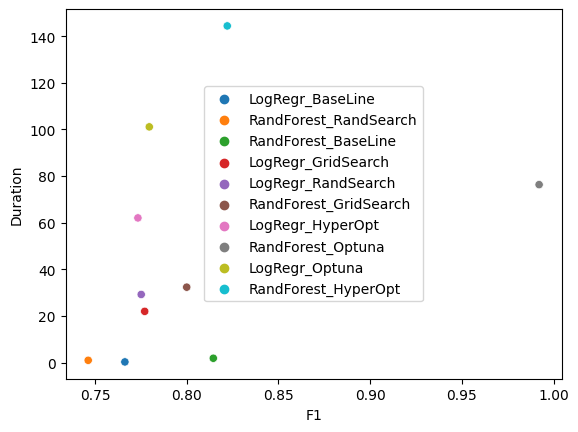

In [120]:
# Визуализируем соотношение 2х параметров - метрики F1 и Duration... 
a = df['F1']
b = df['Duration']
sns.scatterplot(x=a,y=b,hue=df.index)

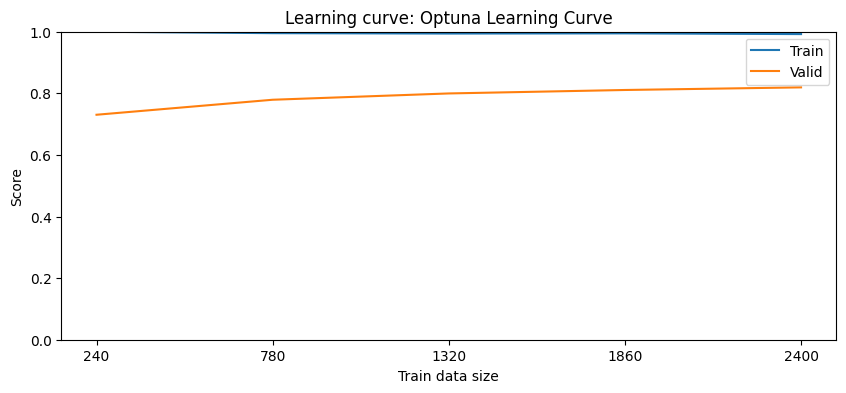

In [121]:
# Посмотрим на кривую обучения Optun-ы...
plot_learning_curve(model, X_train, y_train, cv=skf, scoring="f1", ax=None, title="Optuna Learning Curve")

# **ВЫВОД:** Лучший результат показала Optuma на модели RandomForest